In [1]:
#Qiskit
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.primitives import BackendEstimator
from qiskit_aer.primitives import Estimator

# Qiskit Nature
from qiskit_nature.second_q.hamiltonians.heisenberg_model import HeisenbergModel
from qiskit_nature.second_q.hamiltonians.lattices.line_lattice import LineLattice
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition

# Python
import math
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output

# graphing
import matplotlib.pyplot as plt

In [2]:
# hamiltonian based on qiskit nature's HeiseinbergModel impl - initially produced reversed uu/dd triplet trends & inconsistent singlet energy
def hamiltonian_3rd_party(h:int=0, J=[-1, -1, -1]):
    lattice = LineLattice(2, boundary_condition=BoundaryCondition.PERIODIC)
    heis = HeisenbergModel(lattice, coupling_constants=(J[0], J[1], J[2]), ext_magnetic_field=(0, 0, h))
    matrix = heis.second_q_op().to_matrix()
    # successful fix for reversed uu/dd triplet states + singlet energy:
    # fix basis: ensure nature formula is consistent with the real-valued Heisenberg Hamiltonian from the above link
    for i in range(0, len(matrix)):
        matrix[i] *= -0.5
    return SparsePauliOp.from_operator(Operator(data=matrix))

In [3]:
# all spin-1/2 states
class States:
    
    def __init__(self):
        self.t_uu = QuantumCircuit(2)
        self.t_dd = QuantumCircuit(2)
        self.t = QuantumCircuit(2)
        self.s = QuantumCircuit(2)

        self.set_up_states()

    # private member for composing state circuits to pass to the estimators
    def set_up_states(self):
        self.t_dd.x(0)
        self.t_dd.x(1)

        self.t.h(0)
        self.t.cx(0, 1)
        self.t.x(0)

        self.s.h(0)
        self.s.cx(0, 1)
        self.s.x(0)
        self.s.z(1)

    # 1/sqrt(2)(|01> - |10>)
    def get_singlet(self):
        return self.s

    # |00>
    def get_uu_triplet(self):
        return self.t_uu

    # |11>
    def get_dd_triplet(self):
        return self.t_dd

    # 1/sqrt(2)(|01> + |10>)
    def get_mixed_triplet(self):
        return self.t

In [6]:
# handles all data computation - replaces previously made probe function, since deprecated
class BackendData:
    executor = ThreadPoolExecutor(max_workers=5) 

    def deserialize(fileName):
        h = []
        e = []

        with open(fileName + ".txt", 'r') as file:
            line = file.readline()
            while line != "\n":
                h.append(float(line))
                line = file.readline()
            remaining = file.readlines()

            if (len(remaining) != len(h)):
                raise Exception("Error while deserializeing BackendData file: h and e arrays are not same length!")
            
            for line in remaining:
                e.append(float(line))
        return BackendData(h, e)
    
    def queue(state_circuit, backend=None, shots=1, J=[-1, -1, -1], h=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
        estimator = Estimator() if backend == None else BackendEstimator(backend)
        e = []
        circuits = []
        observables = []
        for h_i in h:
            circuits.append(state_circuit)
            observables.append(hamiltonian_3rd_party(h_i, J))
        res = estimator.run(circuits=circuits, observables=observables).result();
        for e_i in res.values:
            e.append(e_i)
        return e

    def queueAsync(state_circuit, backend=None, shots=1, J=[-1, -1, -1], h=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], callback=(lambda x : None)):
        future = BackendData.executor.submit(BackendData.queue, state_circuit, backend, shots, J, h)
        future.add_done_callback(lambda future : callback(BackendData(h, future.result())))

        return future

    def __init__(self, h, e):
        self.h = h
        self.e = e

    def getMagFieldValues(self):
        return h

    def getEnergyValues(self):
        return e

    def serialize(self, fileName):
        with open(fileName + ".txt", 'w') as file:
            for h_i in self.h:
                file.write(str(h_i) + '\n')
            file.write('\n')
            for e_i in self.e:
                file.write(str(e_i) + '\n')

In [26]:
service = QiskitRuntimeService(channel="ibm_quantum", token="redacted")
backend = service.get_backend(name="ibm_osaka")

In [ ]:
# serialize backend data for all states
states = States()

BackendData.queueAsync(states.get_singlet(), backend=backend, callback=(lambda data: data.serialize("singlet")))
BackendData.queueAsync(states.get_mixed_triplet(), backend=backend, callback=(lambda data: data.serialize("triplet_mixed")))
BackendData.queueAsync(states.get_uu_triplet(), backend=backend, callback=(lambda data: data.serialize("triplet_uu")))
BackendData.queueAsync(states.get_dd_triplet(), backend=backend, callback=(lambda data: data.serialize("triplet_dd")))

In [ ]:
# serialize estimator data for all states
states = States()
 
BackendData.queueAsync(states.get_singlet(), backend=None, callback=(lambda data: data.serialize("singlet_est")))
BackendData.queueAsync(states.get_mixed_triplet(), backend=None, callback=(lambda data: data.serialize("triplet_mixed_est")))
BackendData.queueAsync(states.get_uu_triplet(), backend=None, callback=(lambda data: data.serialize("triplet_uu_est")))
BackendData.queueAsync(states.get_dd_triplet(), backend=None, callback=(lambda data: data.serialize("triplet_dd_est")))

In [4]:
def graph(estimation):
    singlet_data = BackendData.deserialize("singlet" + ("_est" if estimation else ""))
    plt.plot(singlet_data.h, singlet_data.e, label="singlet")

    uu_data = BackendData.deserialize("triplet_uu" + ("_est" if estimation else ""))
    plt.plot(uu_data.h, uu_data.e, label="triplet uu")

    dd_data = BackendData.deserialize("triplet_dd" + ("_est" if estimation else ""))
    plt.plot(dd_data.h, dd_data.e, label="triplet dd")

    mixed_data = BackendData.deserialize("triplet_mixed" + ("_est" if estimation else ""))
    plt.plot(mixed_data.h, mixed_data.e, label="triplet mixed")

    plt.legend(loc="upper left")
    plt.show()

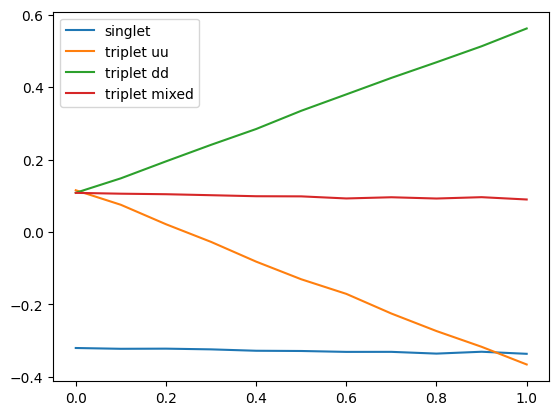

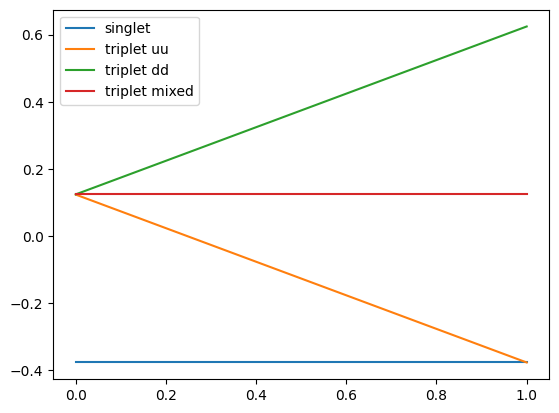

In [7]:
graph(False)
graph(True)